Tiền xử lý & chuẩn hoá về (4800,12,1)

PTBXL_ROOT = /home/cuong/root_data/Master/project_tinyml/database/physionet.org/files/ptb-xl/1.0.1
Batch shapes: (64, 1000, 1) (64, 2)
First sample mean/std: 1.907348723406699e-09 0.9999995231628418
Label count in batch [NORM, AF]: [57.  7.]
Batch shape: (64, 1000, 1) | labels in batch [NORM,AF] = [58  6]

Sample 0: label= NORM | mean(z)=0.000 std(z)=1.000 min=-1.330 max=6.846 
first 12 vals: [-0.216, -0.266, -0.423, -0.621, -0.703, -0.159,  2.878,  6.492,  3.538,
 -0.604, -0.332, -0.39 ]


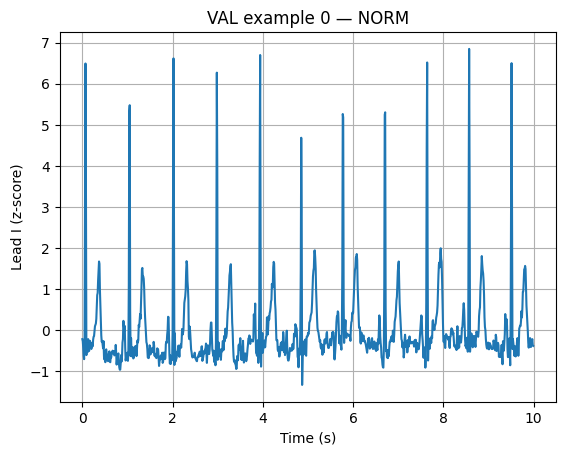


Sample 1: label= NORM | mean(z)=0.000 std(z)=1.000 min=-1.584 max=6.353 
first 12 vals: [ 0.851,  3.723,  5.733,  1.322, -0.229, -0.274, -0.297, -0.251, -0.493,
 -0.32 , -0.412, -0.343]


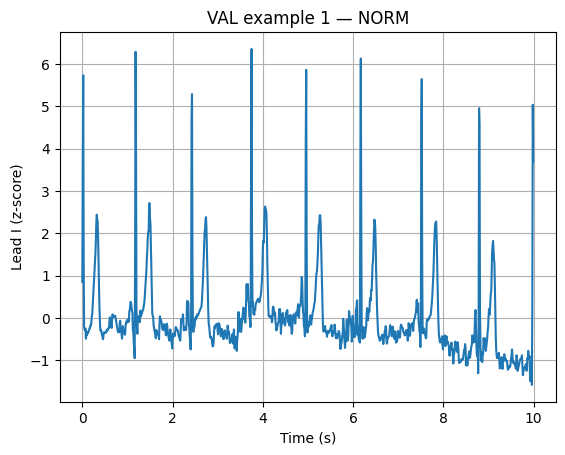


Sample 2: label= NORM | mean(z)=-0.000 std(z)=1.000 min=-1.951 max=6.210 
first 12 vals: [-0.094, -0.162, -0.238, -0.103, -0.128, -0.162, -0.035, -0.061, -0.077,
 -0.086, -0.111, -0.094]


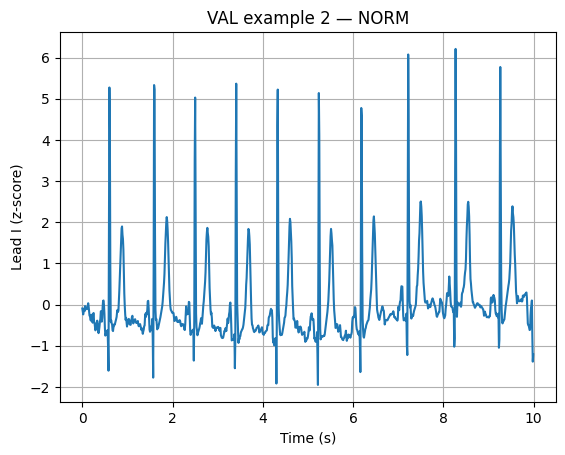

In [19]:
# =========================
# CELL T1' — Tiny generator dùng 100 Hz native (records100) — no resample
# =========================
import os, math, numpy as np, pandas as pd, wfdb
from scipy.signal import resample_poly  # chỉ dùng nếu phải fallback từ 500→100
import tensorflow as tf

with open("ptbxl_root.txt") as f:
    PTBXL_ROOT = f.read().strip()
print("PTBXL_ROOT =", PTBXL_ROOT)

def _hr_to_lr(rel_hr: str) -> str:
    # ví dụ: records500/00000/00001_hr  ->  records100/00000/00001_lr
    return rel_hr.replace("records500", "records100").replace("_hr", "_lr")

class TinyLeadIGenerator(tf.keras.utils.Sequence):
    """
    Đọc Lead I @100Hz, 10s -> (1000,1), z-score theo cửa sổ.
    Ưu tiên records100/*_lr (100 Hz). Nếu thiếu, fallback: records500 + resample 500→100.
    Trả về ({'ecg': X}, y) với X:(B,1000,1), y:(B,2) one-hot [NORM,AF].
    """
    def __init__(self, csv_path, root, batch_size=64, shuffle=True):
        self.df = pd.read_csv(csv_path).dropna(subset=['filename_hr','label']).copy()
        self.root = root
        self.bs = int(batch_size)
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self): return math.ceil(len(self.indices) / self.bs)

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.indices)

    def _read_lead_I_100Hz_10s(self, rel_hr):
        rel_lr = _hr_to_lr(rel_hr)
        base_lr = os.path.join(self.root, rel_lr)
        base_hr = os.path.join(self.root, rel_hr)

        def _zscore_10s(x):
            x = x[:1000] if x.shape[0] >= 1000 else np.pad(x, (0, 1000-x.shape[0]), mode='edge')
            m = float(x.mean()); s = float(x.std()) + 1e-7
            return ((x - m) / s).astype(np.float32)

        # Ưu tiên đọc 100 Hz native nếu có đủ file
        if os.path.exists(base_lr + ".hea") and os.path.exists(base_lr + ".dat"):
            rec = wfdb.rdrecord(base_lr, physical=True)
            names = [s.upper() for s in rec.sig_name]
            if 'I' not in names:
                raise ValueError(f"Thiếu lead I trong {rel_lr}. Leads: {names}")
            sig = rec.p_signal[:, names.index('I')].astype(np.float32)  # thường đúng 1000 mẫu
            return _zscore_10s(sig)
        else:
            # Fallback: đọc 500 Hz rồi resample về 100 Hz
            rec = wfdb.rdrecord(base_hr, physical=True)
            names = [s.upper() for s in rec.sig_name]
            if 'I' not in names:
                raise ValueError(f"Thiếu lead I trong {rel_hr}. Leads: {names}")
            sig = rec.p_signal[:, names.index('I')].astype(np.float32)  # 5000 mẫu
            x = resample_poly(sig, up=1, down=5)  # ~1000
            return _zscore_10s(x)

    def __getitem__(self, idx):
        ids = self.indices[idx*self.bs:(idx+1)*self.bs]
        rows = self.df.iloc[ids]

        X = np.zeros((len(rows), 1000, 1), dtype=np.float32)
        y = np.zeros((len(rows), 2), dtype=np.float32)

        for k, (_, r) in enumerate(rows.iterrows()):
            x = self._read_lead_I_100Hz_10s(r['filename_hr'])
            X[k, :, 0] = x
            y[k, int(r['label'])] = 1.0

        return {'ecg': X}, y

# Khởi tạo lại generators (giữ batch như trước)
BATCH_TINY = 64
train_tiny = TinyLeadIGenerator('split_train.csv', PTBXL_ROOT, batch_size=BATCH_TINY, shuffle=True)
val_tiny   = TinyLeadIGenerator('split_val.csv',   PTBXL_ROOT, batch_size=BATCH_TINY, shuffle=False)
test_tiny  = TinyLeadIGenerator('split_test.csv',  PTBXL_ROOT, batch_size=BATCH_TINY, shuffle=False)

# Smoke test
Xb, yb = train_tiny[0]
print("Batch shapes:", Xb['ecg'].shape, yb.shape)  # (B,1000,1), (B,2)
print("First sample mean/std:", float(Xb['ecg'][0].mean()), float(Xb['ecg'][0].std()))
print("Label count in batch [NORM, AF]:", yb.sum(axis=0))


# CELL V1 — Preview 3 inputs từ VAL (Lead I @100 Hz, 10s), đã z-score
import numpy as np, matplotlib.pyplot as plt

Xb, yb = val_tiny[0]                      # val_tiny đã shuffle=False nên ổn định
ecg = Xb['ecg']                           # shape: (B, 1000, 1)
labels = yb.argmax(axis=1)                # 0=NORM, 1=AF
t = np.arange(ecg.shape[1]) / 100.0       # 100 Hz → giây

print("Batch shape:", ecg.shape, "| labels in batch [NORM,AF] =", yb.sum(axis=0).astype(int))

for i in range(min(3, ecg.shape[0])):     # vẽ 3 mẫu đầu
    x = ecg[i, :, 0]
    print(f"\nSample {i}: label=", "AF" if labels[i]==1 else "NORM",
          "| mean(z)=%.3f std(z)=%.3f min=%.3f max=%.3f" % (x.mean(), x.std(), x.min(), x.max()),
          "\nfirst 12 vals:", np.array2string(x[:12], precision=3, separator=', '))
    plt.figure()
    plt.plot(t, x)                        # không set màu theo yêu cầu
    plt.xlabel("Time (s)"); plt.ylabel("Lead I (z-score)")
    plt.title(f"VAL example {i} — {'AF' if labels[i]==1 else 'NORM'}")
    plt.grid(True); plt.show()




tạo patient-wise split (train/val/test) và lưu ba file CSV

In [20]:
# CELL 2A — Auto-detect PTB-XL root + split patient-wise
import os, re, pandas as pd, numpy as np

CSV_INDEX = "index_ptbxl_af_norm.csv"

# (1) Tự tìm thư mục cha của 'records500'
CANDIDATE_STARTS = [
    ".", "..", "../..", "./ptbxl", "./PTBXL", "./PTB-XL", "./data", "/mnt/data", os.getcwd()
]

def find_ptbxl_root():
    seen = set()
    for start in CANDIDATE_STARTS:
        start = os.path.abspath(start)
        if not os.path.isdir(start) or start in seen:
            continue
        seen.add(start)
        for root, dirs, files in os.walk(start):
            if os.path.basename(root) == "records500":
                # phát hiện đúng cấu trúc con 00000/...
                subs = [d for d in os.listdir(root) if re.fullmatch(r"\d{5}", d)]
                if len(subs) >= 1:
                    return os.path.dirname(root)
    return None

ptbxl_root = find_ptbxl_root()
if ptbxl_root is None:
    raise SystemExit(
        "❌ Không tìm thấy thư mục 'records500'. Hãy sửa CANDIDATE_STARTS hoặc đặt PTBXL_ROOT đúng.\n"
        "Ví dụ cấu trúc chuẩn:\n"
        "  <PTBXL_ROOT>/records500/00000/00001_hr.hea (và .dat)"
    )

print("✅ PTBXL_ROOT:", ptbxl_root)
with open("ptbxl_root.txt", "w") as f:
    f.write(ptbxl_root)

# (2) Load index từ Cell 1
df = pd.read_csv(CSV_INDEX)
assert {'filename_hr','patient_id','age','sex','label'}.issubset(df.columns)
df = df[df['filename_hr'].notna()].copy()
df['patient_id'] = df['patient_id'].astype(int)
df['sex'] = df['sex'].astype(int)

# (3) Giữ lại chỉ các hàng có .hea và .dat tồn tại
def has_files(row):
    p = os.path.join(ptbxl_root, row['filename_hr'])
    return os.path.exists(p + ".hea") and os.path.exists(p + ".dat")

mask = df.apply(has_files, axis=1)
missing = int((~mask).sum())
print(f"🧹 Loại {missing} dòng không tìm thấy file .hea/.dat")
df = df[mask].reset_index(drop=True)
if len(df) == 0:
    raise SystemExit("❌ Không còn mẫu hợp lệ sau khi kiểm tra file.")

# (4) Patient-wise split: 80/10/10
RNG = np.random.default_rng(42)
patients = df['patient_id'].unique()
RNG.shuffle(patients)
n = len(patients)
n_train = int(round(n*0.8)); n_val = int(round(n*0.1)); n_test = n - n_train - n_val

train_p = set(patients[:n_train])
val_p   = set(patients[n_train:n_train+n_val])
test_p  = set(patients[n_train+n_val:])

train_df = df[df['patient_id'].isin(train_p)].copy()
val_df   = df[df['patient_id'].isin(val_p)].copy()
test_df  = df[df['patient_id'].isin(test_p)].copy()

# (5) Sanity checks
assert set(train_df['patient_id']).isdisjoint(val_df['patient_id'])
assert set(train_df['patient_id']).isdisjoint(test_df['patient_id'])
assert set(val_df['patient_id']).isdisjoint(test_df['patient_id'])

# (6) Save
train_df.to_csv('split_train.csv', index=False)
val_df.to_csv('split_val.csv', index=False)
test_df.to_csv('split_test.csv', index=False)

def summary(d):
    vc = d['label'].value_counts().sort_index()
    af = int(vc.get(1,0)); nm = int(vc.get(0,0)); tot = max(1, af+nm)
    return len(d), d['patient_id'].nunique(), af, nm, af/tot

print("\n== Split summary ==")
for name, d in [('TRAIN',train_df),('VAL',val_df),('TEST',test_df)]:
    rows, pats, af, nm, ratio = summary(d)
    print(f"{name}: rows={rows}, patients={pats}, AF={af}, NORM={nm}, AF_ratio={ratio:.3f}")

print("\nℹ️  Đường dẫn gốc đã lưu vào 'ptbxl_root.txt' để dùng ở các cell tiếp theo.")


✅ PTBXL_ROOT: /home/cuong/root_data/Master/project_tinyml/database/physionet.org/files/ptb-xl/1.0.1
🧹 Loại 0 dòng không tìm thấy file .hea/.dat

== Split summary ==
TRAIN: rows=8783, patients=8040, AF=1194, NORM=7589, AF_ratio=0.136
VAL: rows=1081, patients=1005, AF=149, NORM=932, AF_ratio=0.138
TEST: rows=1114, patients=1005, AF=150, NORM=964, AF_ratio=0.135

ℹ️  Đường dẫn gốc đã lưu vào 'ptbxl_root.txt' để dùng ở các cell tiếp theo.


tạo generator Lead I @100 Hz, 10 s (1000×1), chuẩn hoá z-score theo từng cửa sổ, và smoke-test 1 batch.

In [21]:
# =========================
# CELL T1 — Tiny generator: Lead I @100 Hz, 10 s
# =========================
import os, math, numpy as np, pandas as pd, wfdb
from scipy.signal import resample_poly  # up/down-sampling chất lượng tốt
import tensorflow as tf

# Đọc đường dẫn PTB-XL (đã lưu từ trước ở Cell 2A)
with open("ptbxl_root.txt") as f:
    PTBXL_ROOT = f.read().strip()
print("PTBXL_ROOT =", PTBXL_ROOT)

class TinyLeadIGenerator(tf.keras.utils.Sequence):
    """
    Đọc PTB-XL records500 → Lead I → resample 500→100 Hz → 10 s => (1000, 1)
    Chuẩn hoá: z-score theo MỖI cửa sổ (giống sẽ làm trên thiết bị).
    Trả về: ({'ecg': X}, y) với:
        X: (B, 1000, 1) float32
        y: (B, 2) one-hot [NORM, AF]
    """
    def __init__(self, csv_path, root, batch_size=64, shuffle=True):
        self.df = pd.read_csv(csv_path).dropna(subset=['filename_hr','label']).copy()
        self.root = root
        self.bs = int(batch_size)
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.indices) / self.bs)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _read_lead_I_100Hz_10s(self, relpath):
        """
        Trả về ndarray shape (1000,), float32 đã z-score.
        - RD WFDB record
        - Lấy lead 'I' (PTB-XL đặt tên 'I')
        - resample_poly 500→100 (down=5)
        - cắt/pad về đúng 1000 mẫu
        - z-score theo cửa sổ
        """
        base = os.path.join(self.root, relpath)  # .../records500/00000/00001_hr
        rec  = wfdb.rdrecord(base, physical=True)
        names = [s.upper() for s in rec.sig_name]
        try:
            i_lead = names.index('I')
        except ValueError:
            raise ValueError(f"Không tìm thấy lead I trong {relpath}. Leads có: {names}")

        sig = rec.p_signal[:, i_lead].astype(np.float32)  # (5000,)
        # resample 500 Hz → 100 Hz
        x = resample_poly(sig, up=1, down=5)  # ~1000 mẫu
        # Chuẩn hoá chiều dài chính xác 1000
        if x.shape[0] >= 1000:
            x = x[:1000]
        else:
            # pad bằng giá trị cuối để tránh biên giả (ít khi xảy ra)
            pad_len = 1000 - x.shape[0]
            x = np.pad(x, (0, pad_len), mode='edge')
        # z-score theo cửa sổ
        m = float(x.mean())
        s = float(x.std()) + 1e-7
        x = (x - m) / s
        return x.astype(np.float32)

    def __getitem__(self, idx):
        ids = self.indices[idx*self.bs:(idx+1)*self.bs]
        rows = self.df.iloc[ids]

        X = np.zeros((len(rows), 1000, 1), dtype=np.float32)
        y = np.zeros((len(rows), 2), dtype=np.float32)

        for k, (_, r) in enumerate(rows.iterrows()):
            x = self._read_lead_I_100Hz_10s(r['filename_hr'])
            X[k, :, 0] = x
            y[k, int(r['label'])] = 1.0  # 0=NORM, 1=AF

        return {'ecg': X}, y

# Tạo generators từ các split đã có
BATCH_TINY = 64  # nếu RAM/GPU hạn chế có thể hạ 32
train_tiny = TinyLeadIGenerator('split_train.csv', PTBXL_ROOT, batch_size=BATCH_TINY, shuffle=True)
val_tiny   = TinyLeadIGenerator('split_val.csv',   PTBXL_ROOT, batch_size=BATCH_TINY, shuffle=False)
test_tiny  = TinyLeadIGenerator('split_test.csv',  PTBXL_ROOT, batch_size=BATCH_TINY, shuffle=False)

# Smoke test 1 batch
Xb, yb = train_tiny[0]
print("Batch shapes:", Xb['ecg'].shape, yb.shape)  # (B,1000,1), (B,2)
print("First sample mean/std:", float(Xb['ecg'][0].mean()), float(Xb['ecg'][0].std()))
print("Label count in batch [NORM, AF]:", yb.sum(axis=0))


PTBXL_ROOT = /home/cuong/root_data/Master/project_tinyml/database/physionet.org/files/ptb-xl/1.0.1
Batch shapes: (64, 1000, 1) (64, 2)
First sample mean/std: 1.1444091896350983e-08 0.9999991655349731
Label count in batch [NORM, AF]: [50. 14.]


Cell T2: build mô hình tiny 1D DS-CNN cho input Lead I @100 Hz (1000×1), compile, in summary(), rồi smoke-test 1 batch từ train_tiny

In [22]:
# =========================
# CELL T2 — Tiny 1D DS-CNN (Lead I, 1000×1) + smoke test
# =========================
import tensorflow as tf
from tensorflow.keras import layers as L, Model

# (tùy chọn) ổn định GPU mem
try:
    for g in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(g, True)
except Exception as e:
    print("GPU mem growth note:", e)

# Metrics
AUROC = tf.keras.metrics.AUC(curve='ROC', name='auroc')
AUPRC = tf.keras.metrics.AUC(curve='PR',  name='auprc')

def tiny_af_1d(input_len=1000, base=16, num_classes=2, lr=1e-3):
    x_in = L.Input(shape=(input_len, 1), name="ecg")
    # stem
    x = L.Conv1D(base, 9, strides=2, padding="same", use_bias=False)(x_in)
    x = L.BatchNormalization()(x); x = L.ReLU()(x)
    # depthwise-separable blocks
    for ch in [base, base*3//2, base*2]:
        x = L.SeparableConv1D(ch, 9, strides=2, padding="same", use_bias=False)(x)
        x = L.BatchNormalization()(x); x = L.ReLU()(x)
    x = L.GlobalAveragePooling1D()(x)
    out = L.Dense(num_classes, activation="softmax")(x)

    model = Model(x_in, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy", AUROC, AUPRC]
    )
    return model

# Build & summary
model_tiny = tiny_af_1d(input_len=1000, base=16, num_classes=2, lr=1e-3)
model_tiny.summary(line_length=120)

# Smoke test 1 batch từ generator của Cell T1
Xb, yb = train_tiny[0]              # Xb là dict {'ecg': (B,1000,1)}
logs = model_tiny.train_on_batch(Xb, yb)
print("train_on_batch (loss, acc, auroc, auprc):", [float(x) for x in logs])

# Kiểm tra test_on_batch để chắc mọi thứ OK
logs_val = model_tiny.test_on_batch(Xb, yb)
print("test_on_batch  (loss, acc, auroc, auprc):", [float(x) for x in logs_val])


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ ecg (InputLayer)                                    │ (None, 1000, 1)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ conv1d_2 (Conv1D)                                   │ (None, 500, 16)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_8 (BatchNormalization)          │ (None, 500, 16)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ re_lu_8 (ReLU)                                      │ (None, 500, 16)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ separable_conv1d_6 (SeparableConv1D)                │ (None, 250, 16)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_9 (BatchNormalization)          │ (None, 250, 16)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ re_lu_9 (ReLU)                                      │ (None, 250, 16)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ separable_conv1d_7 (SeparableConv1D)                │ (None, 125, 24)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_10 (BatchNormalization)         │ (None, 125, 24)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ re_lu_10 (ReLU)                                     │ (None, 125, 24)                        │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ separable_conv1d_8 (SeparableConv1D)                │ (None, 63, 32)                         │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ batch_normalization_11 (BatchNormalization)         │ (None, 63, 32)                         │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ re_lu_11 (ReLU)                                     │ (None, 63, 32)                         │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ global_average_pooling1d_2 (GlobalAveragePooling1D) │ (None, 32)                             │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ dense_2 (Dense)                                     │ (None, 2)                              │                   
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 2,474 (9.66 KB)

 Trainable params: 2,298 (8.98 KB)

 Non-trainable params: 176 (704.00 B)

/home/cuong/root_data/ai_cnn_env/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ecg
Received: inputs=['Tensor(shape=(64, 1000, 1))']
  warnings.warn(msg)


train_on_batch (loss, acc, auroc, auprc): [0.8024944067001343, 0.203125, 0.250244140625, 0.38618648052215576]
test_on_batch  (loss, acc, auroc, auprc): [0.7468209862709045, 0.4921875, 0.28912353515625, 0.38779449462890625]


Cell T3: train nhanh model tiny

In [23]:
# =========================
# CELL T3 — Train tiny Lead I @100Hz (checkpoint theo val_auroc)
# =========================
import os, pandas as pd, tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

# (tuỳ chọn) giảm retracing / tắt XLA nếu muốn logs gọn:
# tf.config.optimizer.set_jit(False)

# Tính class_weight để bù lệch lớp
tr = pd.read_csv('split_train.csv')
n_pos = int((tr['label'] == 1).sum())
n_neg = int((tr['label'] == 0).sum())
tot   = n_pos + n_neg
class_weight = {0: tot/(2.0*max(1, n_neg)), 1: tot/(2.0*max(1, n_pos))}
print("class_weight:", class_weight, "| counts AF/NORM:", n_pos, n_neg)

# Callbacks
os.makedirs('weights', exist_ok=True)
ckpt_full = ModelCheckpoint(
    filepath='weights/tiny_leadI_full.keras',   # full model để convert TFLite
    monitor='val_auroc', mode='max',
    save_best_only=True, save_weights_only=False, verbose=1
)
early = EarlyStopping(monitor='val_auroc', mode='max', patience=6,
                      restore_best_weights=True, verbose=1)
lrred = ReduceLROnPlateau(monitor='val_auroc', mode='max',
                          factor=0.5, patience=2, min_lr=1e-5, verbose=1)
csvlg = CSVLogger('train_tiny_leadI.csv', append=False)

# Train
EPOCHS = 15
history = model_tiny.fit(
    train_tiny,                  # generator từ Cell T1 (trả về {'ecg': X}, y)
    validation_data=val_tiny,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[ckpt_full, early, lrred, csvlg],
    verbose=1
)

print("✅ Done. Best full model lưu ở: weights/tiny_leadI_full.keras")


class_weight: {0: 0.5786664909737779, 1: 3.6779731993299833} | counts AF/NORM: 1194 7589


/home/cuong/root_data/ai_cnn_env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/home/cuong/root_data/ai_cnn_env/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ecg
Received: inputs=['Tensor(shape=(None, 1000, 1))']
  warnings.warn(msg)


138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.6044 - auprc: 0.7193 - auroc: 0.6865 - loss: 0.5473
Epoch 1: val_auroc improved from None to 0.96732, saving model to weights/tiny_leadI_full.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 34s 225ms/step - accuracy: 0.7811 - auprc: 0.8913 - auroc: 0.8883 - loss: 0.4220 - val_accuracy: 0.8622 - val_auprc: 0.9689 - val_auroc: 0.9673 - val_loss: 0.4616 - learning_rate: 0.0010
Epoch 2/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9246 - auprc: 0.9775 - auroc: 0.9776 - loss: 0.1915
Epoch 2: val_auroc improved from 0.96732 to 0.97959, saving model to weights/tiny_leadI_full.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.9361 - auprc: 0.9829 - auroc: 0.9831 - loss: 0.1671 - val_accuracy: 0.8622 - val_auprc: 0.9808 - val_auroc: 0.9796 - val_loss: 0.3314 - learning_rate: 0.0010
Epoch 3/15
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9564 - auprc: 0.9903 - auroc: 0.9906 - loss: 0.1170
Epoch 3: val_auroc impro

In loss/accuracy từng epoch từ đối tượng history

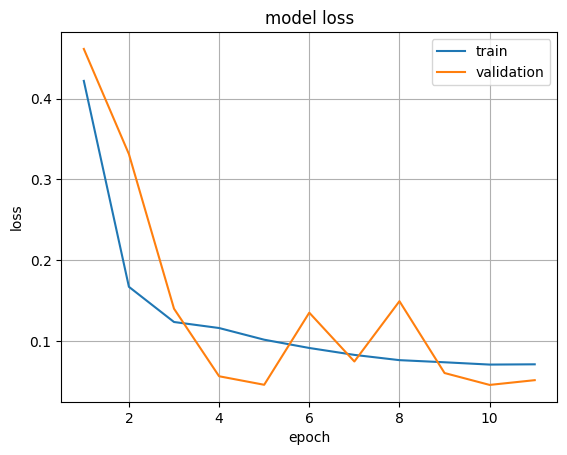

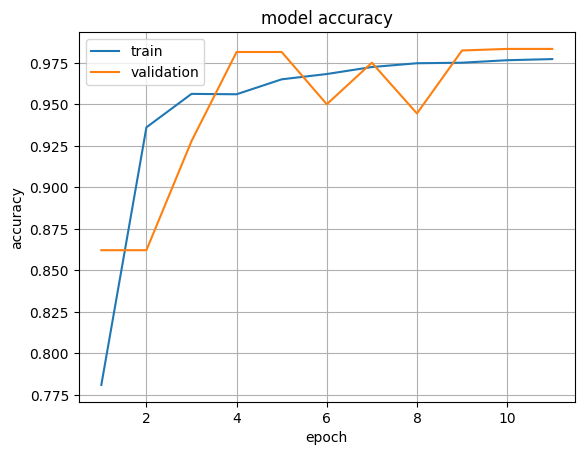

In [24]:
import matplotlib.pyplot as plt
import numpy as np

h = history.history  # dict: 'loss','accuracy','val_loss','val_accuracy', ...

epochs = np.arange(1, len(h['loss']) + 1)

# Loss
plt.figure()
plt.plot(epochs, h['loss'], label='train')
plt.plot(epochs, h['val_loss'], label='validation')
plt.title('model loss')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.legend(); plt.grid(True)
plt.show()

# Accuracy
plt.figure()
plt.plot(epochs, h['accuracy'], label='train')
plt.plot(epochs, h['val_accuracy'], label='validation')
plt.title('model accuracy')
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.legend(); plt.grid(True)
plt.show()


Đánh giá trên TEST

In [25]:
# CELL T6b — Chọn threshold từ validation rồi áp lên test
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, confusion_matrix
import keras

mdl_tiny = keras.saving.load_model('weights/tiny_leadI_full.keras')

# --- Val ---
yv, pv = [], []
for X,y in val_tiny:
    pv.append(mdl_tiny.predict(X, verbose=0)[:,1])
    yv.append(y[:,1])
yv = np.concatenate(yv); pv = np.concatenate(pv)
fpr, tpr, thr = roc_curve(yv, pv)
thr_youden_val = thr[(tpr - fpr).argmax()]
print(f"[VAL] Youden threshold = {thr_youden_val:.4f}")

# (tuỳ chọn) chọn ngưỡng đạt recall >= 0.95 trên val:
idx95 = np.argmax(tpr >= 0.95)
thr_rec95 = thr[idx95] if idx95 > 0 else 0.5
print(f"[VAL] Threshold for recall>=0.95 = {thr_rec95:.4f}")

# --- Test với 2 ngưỡng trên ---
def eval_on_test(th):
    yt, pt = [], []
    for X,y in test_tiny:
        pt.append(mdl_tiny.predict(X, verbose=0)[:,1])
        yt.append(y[:,1])
    yt = np.concatenate(yt); pt = np.concatenate(pt)
    pred = (pt >= th).astype(int)
    cm = confusion_matrix(yt, pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    acc = (tp+tn)/cm.sum()
    prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
    f1 = 2*prec*rec/(prec+rec+1e-9)
    print(f"\n[TEST] @thr={th:.4f}  ACC={acc:.4f}  PREC={prec:.4f}  REC={rec:.4f}  F1={f1:.4f}")
    print("CM [[TN FP],[FN TP]]:\n", cm)

eval_on_test(thr_youden_val)
eval_on_test(thr_rec95)


/home/cuong/root_data/ai_cnn_env/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ecg
Received: inputs=['Tensor(shape=(32, 1000, 1))']
  warnings.warn(msg)


[VAL] Youden threshold = 0.1986
[VAL] Threshold for recall>=0.95 = 0.2926

[TEST] @thr=0.1986  ACC=0.9749  PREC=0.8506  REC=0.9867  F1=0.9136
CM [[TN FP],[FN TP]]:
 [[938  26]
 [  2 148]]

[TEST] @thr=0.2926  ACC=0.9749  PREC=0.8812  REC=0.9400  F1=0.9097
CM [[TN FP],[FN TP]]:
 [[945  19]
 [  9 141]]
